## **Subcluster Ranking and Selection**

This notebook ranks subclusters using a weighted sum of three metrics:

- **Size:** Number of entries in the subcluster.
- **Cohesion:** How tightly grouped the entries are (intra-cluster similarity).
- **Separation:** How distinct the subcluster is from others (inter-cluster dissimilarity).

Each parent cluster is processed using:

- Sentence embeddings (`all-mpnet-base-v2`)
- K-Means for subclustering
- PCA for dimensionality reduction
- UMAP for visualization

Subclusters are ranked and used for downstream FAQ generation.

## **Setup and Configuration**
- Mount Google Drive (if using Colab).
- Import libraries for embedding, clustering, visualization, and I/O.
- Configure data source (`tdx` or `anvil`)

In [1]:
# Mount Google Drive (if using Colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Core libraries
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# Embedding and similarity
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, normalize

# Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import umap.umap_ as umap

# Utility
from collections import defaultdict
import csv

## **Load Data and Initialize Model**
- Read ticket summaries and cluster assignments.
- Merge and clean the combined dataset.
- Load `all-mpnet-base-v2` sentence embedding model with GPU support.



In [26]:
ticket_src = "anvil"  # Options: "tdx" or "anvil"

# Load data
df_tickets = pd.read_csv(f'/content/drive/MyDrive/Colab Notebooks/TicketHub/{ticket_src}_ticket_summaries.csv')
df_clusters = pd.read_csv(f'/content/drive/MyDrive/Colab Notebooks/TicketHub/{ticket_src}_clusters.csv')

# Merge datasets
df_merged = pd.merge(df_clusters, df_tickets, on='issuenumber', how='inner')
df_merged.drop(['title', 'titlenostopwords'], axis=1, inplace=True)


In [27]:
df_merged.head()

,issuenumber,cluster,clustername,issue_summary,resolution
0,ATS-1632,2,"vasp, license, access, request",User needs to be added to vasp6 license and in...,The user has been added to the vasp6 group on ...
1,ATS-1636,8,"quota, storage, disk, increase",Requirement for a significant increase in quot...,"To address the user's requirement, you can con..."
2,ATS-1643,0,"job, jobs, node, running",User wants to test and potentially move projec...,To access and run code on the Anvil supercompu...
3,ATS-1668,0,"job, jobs, node, running",User encountered an error when submitting a sb...,The error indicates that the user's required r...
4,ATS-1726,5,"directory, project, projects, files",The user is experiencing an issue with the fil...,The engineering team is working on resolving t...


In [28]:
# Count entries per cluster
cluster_counts = df_merged['cluster'].value_counts()

# Load sentence transformer model
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2', device='cuda')

## **Helper Functions**
The following functions support clustering and scoring tasks:
- `compute_best_k`: Determines optimal number of subclusters using silhouette score.
- `subcluster_embeddings_kmeans`: Applies K-Means to generate subclusters.
- `compute_cohesion`: Measures how tightly packed a subcluster is.
- `compute_separation`: Measures how distinct a subcluster is from others.
- `visualize_subclusters`: Projects embeddings into 2D using UMAP.
- `get_top_entries_by_centroid`: Ranks entries by similarity to centroid.



### **Optimal K Calculation**

In [29]:
# Compute the optimal number of clusters per parent cluster by iterating through choices from 2 to 4
def compute_best_k(X, total):

    candidate_scores = [] # Keeps track of the best k and its corresponding silhouette score

    for k in range(2, 5): # Iterates through k values from 2 to 4 (found to be the best balance between over- and underfitting due to the parent cluster sizes (~90 tickets))
          labels = KMeans(n_clusters=k, random_state=42, n_init=50).fit(X).labels_ # Number of times k-means runs with different centroid seeds (n_init=50) to ensure robustness to high-dimensionality
          unique, counts = np.unique(labels, return_counts=True)

          max_prop = counts.max() / total

          # Skip if any subcluster has fewer than 5 tickets or is overly imbalanced
          if np.any(counts < 5) or max_prop > 0.85:
            continue

          # Compute Silhouette Score
          silo_score = silhouette_score(X, labels)

          candidate_scores.append((k, silo_score))

    # Select best k based on the highest Silhouette Score
    if candidate_scores:  # Check if the list is not empty
        candidate_scores.sort(key=lambda x: -x[1])  # Sort in Descending Order (Highest Silhouette is the best)
        best_k = candidate_scores[0][0]
    else:
        best_k = 1  # Return 1 if no suitable k is found

    return best_k

### **Subclustering**

In [30]:
def subcluster_embeddings_kmeans(embeddings, k):
    """
    Applies KMeans clustering to group high-dimensional sentence embeddings into subclusters.

    """
    kmeans = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=50
    )

    # Fit the model and predict cluster labels
    labels = kmeans.fit_predict(embeddings)

    # Extract the cluster centroids for downstream use (e.g., visualization, scoring)
    centroids = kmeans.cluster_centers_

    return labels, centroids


### **Cohesion & Separation**

In [31]:
def compute_cohesion(embeddings):
    """
    Measures intra-subcluster similarity by computing the average pairwise cosine similarity
    between all vectors in a subcluster. This gives a proxy for how "tight" or cohesive a group is.

    Closer to 1 = more cohesive and tighter clusters
    Closer to 0 = less cohesive and more scattered clusters

    """
    # Re-normalize again since we are using cosine similarity
    embeddings = normalize(embeddings)

    # Get number of embedding vectors
    n_samples = embeddings.shape[0]

    # Compute cosine similarity matrix (n_samples x n_samples)
    sim_matrix = cosine_similarity(embeddings)

    # Compute total sum of similarities
    total_sim = np.sum(sim_matrix)

    # Subtract self-similarity
    diagonal = np.trace(sim_matrix)

    # Normalize by number of unique pairwise comparisons
    return (total_sim - diagonal) / (n_samples * (n_samples - 1))

In [32]:
def compute_separation(embeddings_a, embeddings_b):
    """
    Measures inter-subcluster dissimilarity by computing the average pairwise cosine distance
    between vectors from different subclusters. This provides an indication of how distinct or
    well-separated the groups are from each other.

    Return the complement of the separation score to have high values be ideal.

    The equation used is the average linkage clustering formula
    """

    # Re-normalize again since we are using cosine similarity
    embeddings_a = normalize(embeddings_a)
    embeddings_b = normalize(embeddings_b)

    # Calculate cross-cluster similarity matrix
    sim_matrix = cosine_similarity(embeddings_a, embeddings_b)

    # Sum all pairwise similarities
    total_sim = np.sum(sim_matrix)

    # Normalize by number of cross-cluster comparisons
    n_comparisons = embeddings_a.shape[0] * embeddings_b.shape[0]

    # Return the complement of the separation score
    return 1 - (total_sim / n_comparisons)

### **Visualizer**

In [33]:
# Visualize subclusters using UMAP projection into 2D space

def visualize_subclusters(embeddings, labels, cluster_name, method="umap"):
    """
    Visualizes subclusters using UMAP dimensionality reduction.

    """
    reducer = umap.UMAP(n_components=2, random_state=42)

    reduced = reducer.fit_transform(embeddings)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x=reduced[:, 0],
        y=reduced[:, 1],
        hue=labels,
        palette='tab10',
        legend='full'
    )
    plt.title(f"Subclusters for Cluster {cluster_name}")
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.legend(title="Subcluster")
    plt.tight_layout()
    plt.show()


### **Top Entries by Centroid**

In [34]:
def get_top_entries_by_centroid(embeddings, centroid, df):
  """
  Returns a sorted list of issue summaries and resolutions ordered by which embeddings are most similar to the centroid.
  """
  # Ensure inputs are 2D
  centroid = centroid.reshape(1,-1)

  # Normalize both embeddings and centroid since we are using cosine similarity
  norm_embeddings = normalize(embeddings)
  norm_centroid = normalize(centroid)

  # Compute cosine similarities
  similarities = cosine_similarity(norm_embeddings, norm_centroid).flatten()

  # Sort by most similar indices
  top_indices = similarities.argsort()[::-1]

  # Extract text
  top_summaries = df.loc[top_indices, 'issue_summary'].tolist()
  top_resolutions = df.loc[top_indices, 'resolution'].dropna().tolist()

  return top_summaries, top_resolutions

## **Process Parent Clusters**
For each parent cluster:
- Embed summaries and apply PCA for dimensionality reduction.
- Run K-Means with optimal k to form subclusters.
- Normalize embeddings and store per-subcluster metadata (e.g., cohesion, separation).
- Rank entries within each subcluster by cosine similarity to the centroid.
- Visualize subclusters with UMAP.



Cluster '0' → KMeans selected k = 2


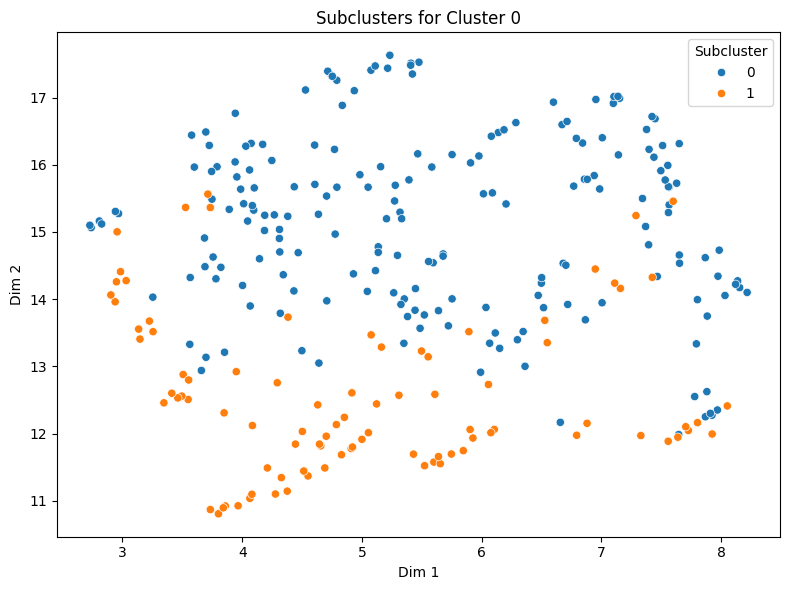

Cluster '1' → KMeans selected k = 4


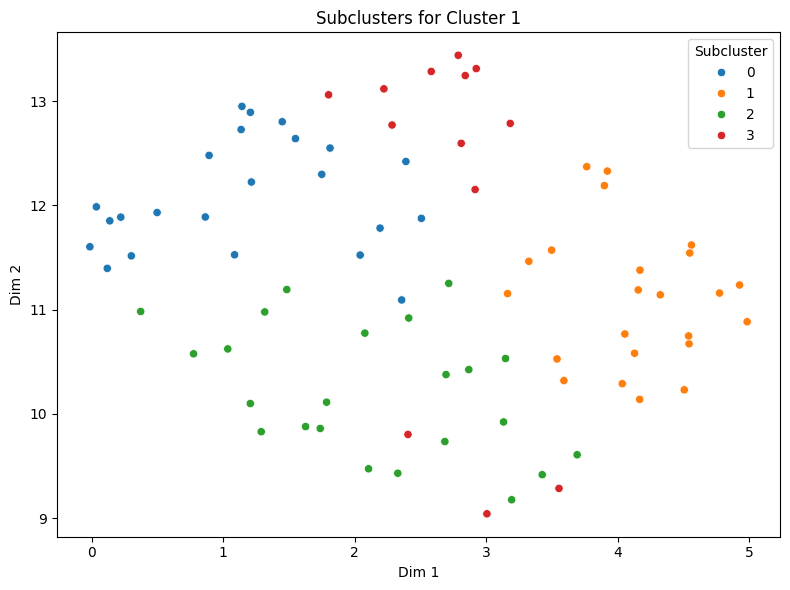

Cluster '3' → KMeans selected k = 4


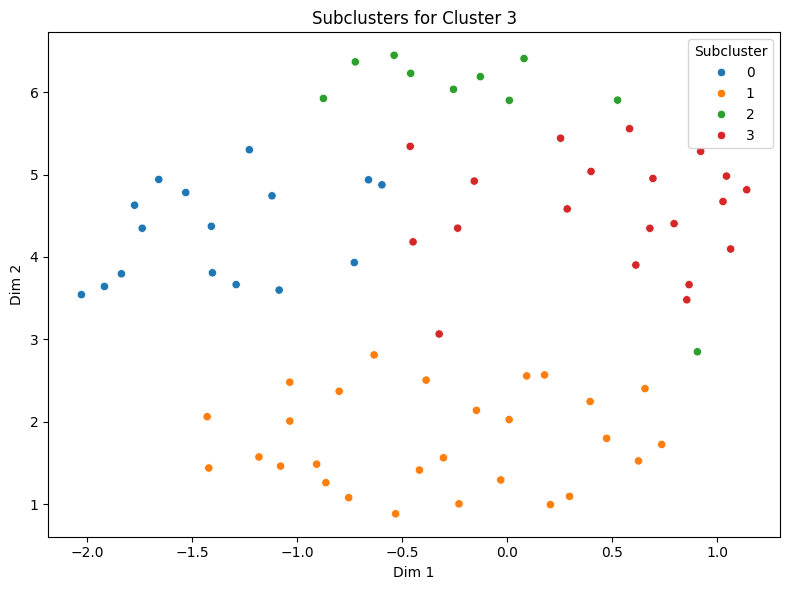

Cluster '2' → KMeans selected k = 2


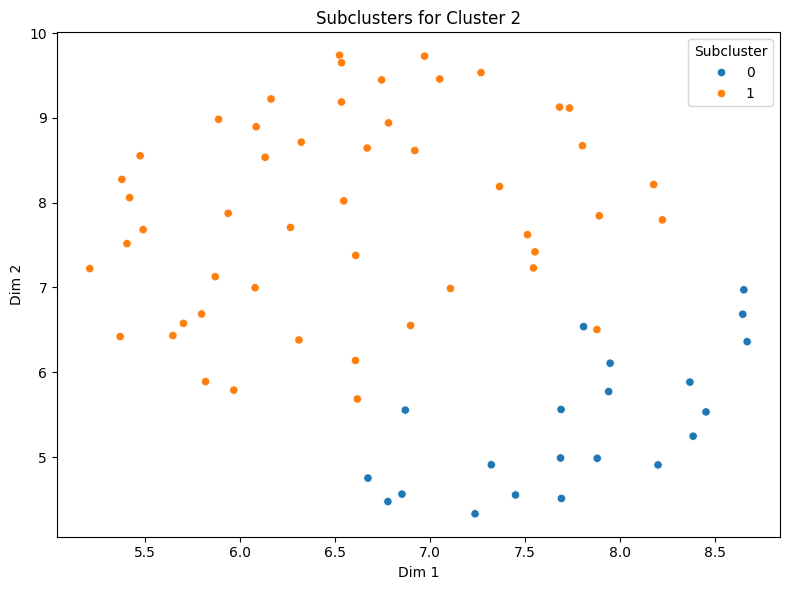

Cluster '5' → KMeans selected k = 4


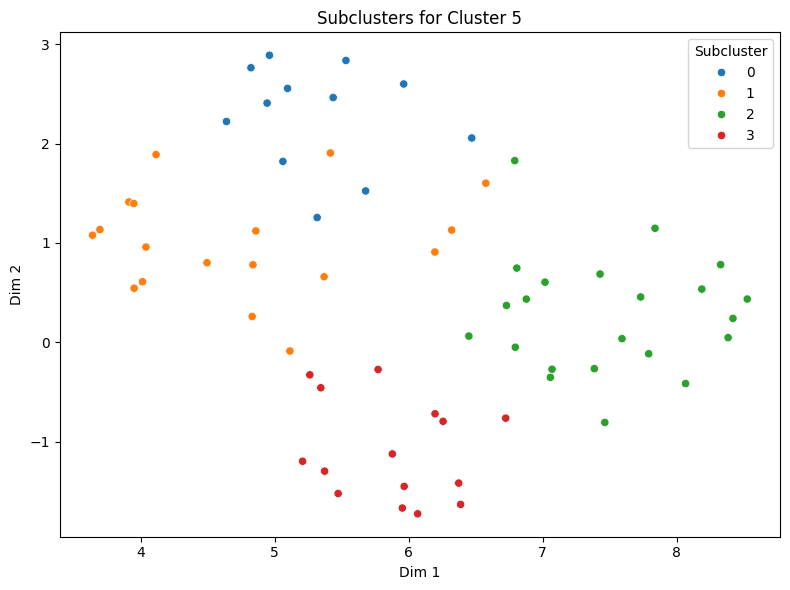

Cluster '8' → KMeans selected k = 2


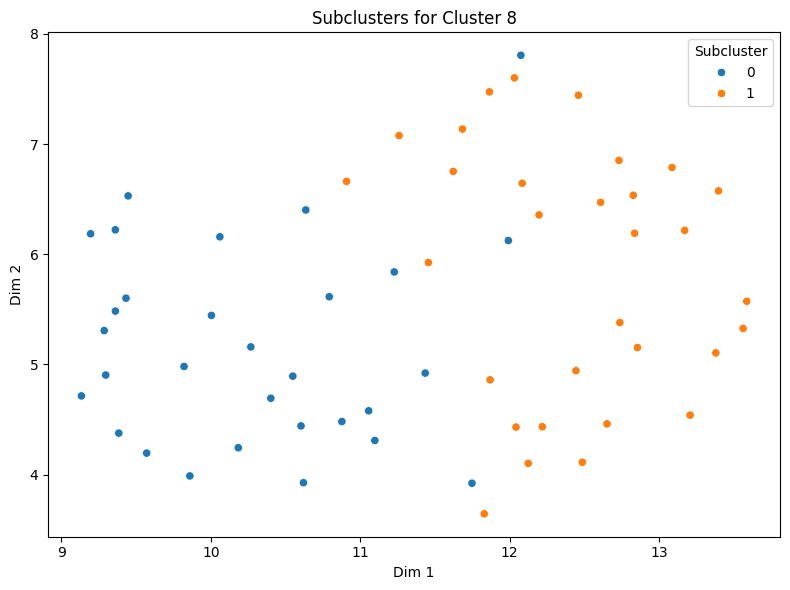

Cluster '16' → KMeans selected k = 2


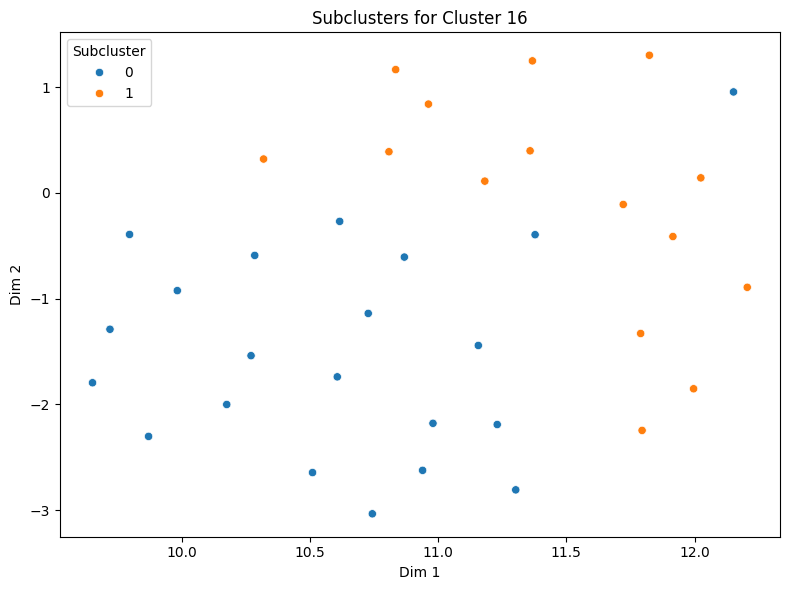

In [35]:
# Store metadata for every subcluster
global_subcluster_stats = []

# Iterate through parent clusters
for cluster_id, total in cluster_counts.items():

    # Retrieve the issue summaries associated with the given parent cluster
    cluster_df = df_merged[df_merged['cluster'] == cluster_id].reset_index(drop=True)
    summaries_all = cluster_df['issue_summary'].tolist()

    # Generate embeddings and reduce dimensionality
    embeddings = model.encode(summaries_all, batch_size=16, normalize_embeddings=True)
    pca = PCA(n_components=10, random_state=42)
    embeddings = pca.fit_transform(embeddings)

    # Subcluster with KMeans
    k = compute_best_k(embeddings, len(cluster_df))

    # Edge Case: if k=1 skip this parent cluster
    if k == 1:
      continue

    labels, centroids = subcluster_embeddings_kmeans(embeddings, k=k)

    print(f"Cluster '{cluster_id}' → KMeans selected k = {k}")

    # For visualization across all subclusters
    all_sub_embeddings = []
    all_sub_labels = []

    # First pass: process all subclusters
    subclusters = []

    for sub_id in range(k):
        # Retrieve the entries and embeddings associated with a given subcluster
        mask = (labels == sub_id)
        sub_df = cluster_df[mask].reset_index(drop=True)
        sub_embeddings = embeddings[mask]

        # Append these embeddings and their subcluster label for visualization purposes
        all_sub_embeddings.append(sub_embeddings)
        all_sub_labels.extend([sub_id] * len(sub_embeddings))

        # Save data for scoring in second pass
        subclusters.append({
            'sub_id': sub_id,
            'df': sub_df,
            'embeddings': sub_embeddings,
        })

    # Second pass: compute cohesion and separation
    for subcluster in subclusters:
        sub_id = subcluster['sub_id']
        sub_df = subcluster['df']
        embeddings_a = subcluster['embeddings']

        size = len(sub_df)
        cohesion = compute_cohesion(embeddings_a)

        # Compute separation from all other subclusters
        separations = []
        for other in subclusters:
            if other['sub_id'] == sub_id:
                continue
            embeddings_b = other['embeddings']
            sep_score = compute_separation(embeddings_a, embeddings_b)
            separations.append(sep_score)

        # Compute the mean separation
        separation = np.mean(separations) if separations else 0.0

        # Sort issue summary and resolutions per entry by similarity/dissimilarity of issue summary with the centroid
        centroid = centroids[sub_id]
        top_summaries, top_resolutions = get_top_entries_by_centroid(
        embeddings=embeddings_a,
        centroid=centroid,
        df=sub_df)

        # Store stats
        global_subcluster_stats.append({
            'cluster': cluster_id,
            'subcluster_id': sub_id,
            'summaries': sub_df['issue_summary'].tolist(),
            'resolutions': sub_df['resolution'].dropna().tolist(),
            'size': size,
            'cohesion': cohesion,
            'separation': separation,
            'embeddings': embeddings_a,
        })

    # Visualize subclusters
    if all_sub_embeddings:
        all_sub_embeddings = np.vstack(all_sub_embeddings)
        all_sub_labels = np.array(all_sub_labels)
        visualize_subclusters(
            all_sub_embeddings,
            labels=all_sub_labels,
            cluster_name=f"{cluster_id}"
        )


## **Score and Rank Subclusters**
- Normalize subcluster sizes using MinMaxScaler.
- Combine normalized size, cohesion, and separation into a final score using configurable weights.
- Print diagnostic output for each subcluster.

In [36]:
def compute_ranked_scores(subclusters, size_weight, cohesion_weight, separation_weight):
    """
    Assigns a global score to each subcluster across all parent clusters based on:
      - Size: number of items in the subcluster (percentile rank)
      - Cohesion: tightness of the subcluster (z-score; higher = better)
      - Separation: distinctiveness of the subcluster (z-score; higher = better)

    The final score is a weighted combination of all three metrics.
    """

    # Extract raw metrics
    sizes = np.array([s["size"] for s in subclusters])
    cohesions = np.array([s["cohesion"] for s in subclusters])
    separations = np.array([s["separation"] for s in subclusters])

    # Normalize size metric only
    scaler = MinMaxScaler()
    normalized_sizes = scaler.fit_transform(sizes.reshape(-1, 1)).flatten()


    # Assign final score to each subcluster
    for i, s in enumerate(subclusters):
        score = (
            size_weight * normalized_sizes[i] +
            cohesion_weight * cohesions[i] +
            separation_weight * separations[i]
        )

        # Store rank/z details
        s["normalized_size"] = normalized_sizes[i]
        s["score"] = score

        print(f"Parent Cluster {s['cluster']} → "
              f"Subcluster {s['subcluster_id']} → "
              f"size: {normalized_sizes[i]:.2f}, "
              f"cohesion: {cohesions[i]:.2f}, "
              f"separation: {separations[i]:.2f}, "
              f"final score: {score:.2f}")

    return subclusters


## **Filter and Select Top Subclusters**
- Remove subclusters that are too small or too large based on configurable thresholds:
  - `MIN_SIZE`: discard tiny subclusters (too specific).
  - `MAX_SIZE`: discard huge subclusters (too broad).
- Sort subclusters by score and select top NUM_FAQs for downstream FAQ generation.



In [37]:
MIN_SIZE = 0.05     # Too small = too specific
MAX_SIZE = 0.80     # Too big = overly broad
EPSILON = 1e-3 # epsilon threshold to overcome floating point approximation
NUM_FAQs = 20  # number of subclusters to save to a CSV for LLM input

In [ ]:
# Score and normalize
updated_subclusters = compute_ranked_scores(
    global_subcluster_stats,
    size_weight=0.4,
    cohesion_weight=1.2,
    separation_weight=0.2
)

# Filter based on size thresholds
filtered = [
    s for s in updated_subclusters
    if (s.get("normalized_size", 0) > MIN_SIZE + EPSILON) and
       (s.get("normalized_size", 0) < MAX_SIZE - EPSILON)
]

# Sort by score
ranked = sorted(filtered, key=lambda x: x["score"], reverse=True)

# Select top 20 for FAQ generation
top_faq_subclusters = ranked[:NUM_FAQs]

Parent Cluster 0 → Subcluster 0 → size: 1.00, cohesion: 0.06, separation: 1.12, final score: 0.70
Parent Cluster 0 → Subcluster 1 → size: 0.44, cohesion: 0.22, separation: 1.12, final score: 0.67
Parent Cluster 1 → Subcluster 0 → size: 0.07, cohesion: 0.33, separation: 1.11, final score: 0.64
Parent Cluster 1 → Subcluster 1 → size: 0.07, cohesion: 0.32, separation: 1.13, final score: 0.64
Parent Cluster 1 → Subcluster 2 → size: 0.07, cohesion: 0.17, separation: 1.08, final score: 0.45
Parent Cluster 1 → Subcluster 3 → size: 0.02, cohesion: 0.37, separation: 1.10, final score: 0.67
Parent Cluster 3 → Subcluster 0 → size: 0.03, cohesion: 0.24, separation: 1.07, final score: 0.52
Parent Cluster 3 → Subcluster 1 → size: 0.10, cohesion: 0.31, separation: 1.19, final score: 0.65
Parent Cluster 3 → Subcluster 2 → size: 0.00, cohesion: 0.48, separation: 1.08, final score: 0.79
Parent Cluster 3 → Subcluster 3 → size: 0.05, cohesion: 0.26, separation: 1.07, final score: 0.55
Parent Cluster 2 → S

In [40]:
print("\nTop 20 FAQ Subclusters:\n")
for i, s in enumerate(top_faq_subclusters):
    print(f"{i+1}. Parent Cluster {s['cluster']} → Subcluster {s['subcluster_id']}")
    print(f"   Final Score: {s['score']:.2f}")
    print(f"   Normalized Size: {s['normalized_size']:.2f}")
    print(f"   # Summaries: {len(s['summaries'])}")
    print(f"   # Resolutions: {len(s['resolutions'])}")

    # Optionally print a few examples
    print("   Sample Summary:", s['summaries'][0][:120] + "..." if s['summaries'] else "None")
    print("   Sample Resolution:", s['resolutions'][0][:120] + "..." if s['resolutions'] else "None")
    print("-" * 80)



Top 20 FAQ Subclusters:

1. Parent Cluster 0 → Subcluster 1
   Final Score: 0.67
   Normalized Size: 0.44
   # Summaries: 91
   # Resolutions: 91
   Sample Summary: User wants to test and potentially move projects to Purdue's Anvil CPU supercomputer due to concerns about Stampede3 sys...
   Sample Resolution: To access and run code on the Anvil supercomputer, the user should submit a Supplement for additional SUs (Stored Units)...
--------------------------------------------------------------------------------
2. Parent Cluster 3 → Subcluster 1
   Final Score: 0.65
   Normalized Size: 0.10
   # Summaries: 28
   # Resolutions: 28
   Sample Summary: The user is experiencing issues with their access to the Purdue Anvil machine's Job Composer and Shell Access. The issue...
   Sample Resolution: The issue appears to be caused by the user's home directory being full (101% used). To resolve this, the user should rem...
-------------------------------------------------------------------------

## **Export FAQ Candidates to CSV**
- Write top subclusters (with metadata and full tet) to `top_faq_candidates.csv`
- Provide delimiter `|||` to separate entries within single CSV cels
- Download the file directly in Google Colab  

In [41]:
with open(f"{ticket_src}_top_faq_candidates.csv", "w", newline="", encoding="utf-8") as csvfile:
    writer = csv.writer(csvfile)

    # Header
    writer.writerow([
        "Cluster", "Subcluster_ID", "Num_Summaries",
        "Num_Resolutions", "All_Summaries", "All_Resolutions"
    ])

    for s in top_faq_subclusters:
        summaries_str = " ||| ".join(s["summaries"])
        resolutions_str = " ||| ".join(s["resolutions"]) if s["resolutions"] else ""

        writer.writerow([
            s["cluster"],
            s["subcluster_id"],
            len(s["summaries"]),
            len(s["resolutions"]),
            summaries_str,
            resolutions_str
        ])

In [42]:
# Download "top_faq_candidates.csv" from previous code cell
from google.colab import files
files.download(f"{ticket_src}_top_faq_candidates.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>